In [1]:
import glob
import math
from typing import Tuple
from pprint import pprint
from tqdm import tqdm

# Traditional imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Dask imports
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

### Load Sentinel-1 Images Index ###

In [2]:
data_index_path = "/ds2/remote_sensing/ben-ge/ben-ge/ben-ge_meta.csv" 
index_df = pd.read_csv(data_index_path)

In [3]:
index_df.head(2)

,patch_id,patch_id_s1,timestamp_s2,timestamp_s1,season_s2,season_s1,lon,lat
0,S2B_MSIL2A_20180204T94161_57_38,S1A_IW_GRDH_1SDV_20180204T043253_35VPK_57_38,2018-02-04 09:41:56,2018-02-04 04:32:53,0.36662,0.36662,30.30100,62.67602
1,S2B_MSIL2A_20170924T93020_69_24,S1A_IW_GRDH_1SDV_20170925T043256_35VPK_69_24,2017-09-24 09:30:20,2017-09-25 04:32:56,0.68913,0.68278,30.59994,62.81962


### Load Sentinel-1 Files ###

In [4]:
sentinel_1_root_path = "/ds2/remote_sensing/ben-ge/ben-ge/sentinel-1"
filenames = [f"{sentinel_1_root_path}/{patch_id}/{patch_id}_all_bands.npy" for patch_id in index_df["patch_id_s1"]]

In [5]:
def read_one_image(block_id, filenames=filenames, axis=0):
    # a function that reads in one chunk of data
    path = filenames[block_id[axis]]
    image = np.load(path)
    return np.expand_dims(image, axis=axis)

# load the first image (assume rest are same shape/dtype)
sample = np.load(filenames[0])

stack = da.map_blocks(
    read_one_image,
    dtype=sample.dtype,
    chunks=((1,) * len(filenames),  *sample.shape)
)

In [6]:
stack

dask.array<read_one_image, shape=(590326, 2, 120, 120), dtype=float32, chunksize=(1, 2, 120, 120), chunktype=numpy.ndarray>

### Compute Channelwise Sentinel 1 Statistics  ###

In [7]:
channels = [stack[:, i, ::] for i in range(2)]
s1_stats = [
    getattr(stack, stat)(axis=(0,2,3))
    for stat in ["min", "max", "mean", "std"]
]

s1_stats += [da.histogram(channel, bins=100, range=(-100, 100)) for channel in channels]

### Run Computation ###

In [8]:
with ProgressBar():
    stats_result = da.compute(*s1_stats)

[                                        ] | 0% Completed | 59.24 sus

IOStream.flush timed out


[########################################] | 100% Completed | 106m 41s


In [9]:
import pickle
with open("./s1_stats_result.pkl", "wb") as out_file:
    pickle.dump(stats_result, out_file)

### Compute Quantiles from histogram ###

In [10]:
def calculate_percentile_from_histogram(hist_counts, hist_bins, p=0.5):
    n = hist_counts.sum()
    quantile_index = int(p*n)
    
    # Find bin in which quantile index is placed
    cum_sum = 0
    bin_index = 0
    for i, counts in enumerate(hist_counts):
        cum_sum += counts
        # If cumulative sum exceeds quantile index stop
        if cum_sum > quantile_index:
            bin_index = i
            break

    # Calculate bin value
    bin_lower = hist_bins[i]
    bin_width = abs(hist_bins[i+1] - bin_lower)
    overstep = cum_sum - quantile_index
    
    # Divide overstep by amount of samples in the bin
    bin_value = overstep / hist_counts[bin_index] 
    return bin_lower + bin_value

In [11]:
max_values, min_values, mean_values, std_values, histogram_values_0, histogram_values_1  = stats_result

In [12]:
def pretty_histogram(histogram_values: Tuple[np.ndarray, np.ndarray]):
    hist_counts, hist_bins = histogram_values
    pprint({ k: calculate_percentile_from_histogram(hist_counts, hist_bins, p=k) for k in np.arange(0.25, 1.0, 0.25)})
    plt.stairs(hist_counts, hist_bins, fill=True)

{0.25: -23.78701777282265, 0.5: -19.95537312167313, 0.75: -15.34850768715068}


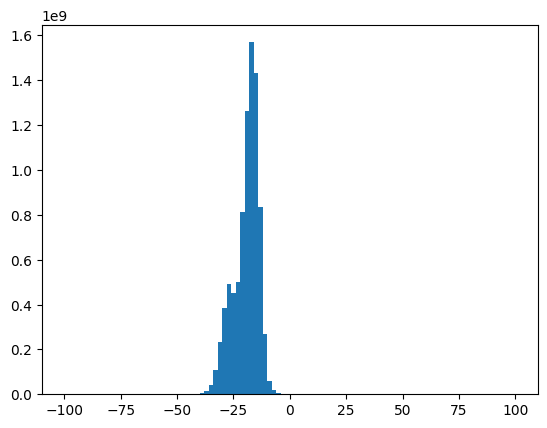

In [13]:
pretty_histogram(histogram_values_0)

{0.25: -15.573709484425992, 0.5: -11.144907591102903, 0.75: -9.374460728664191}


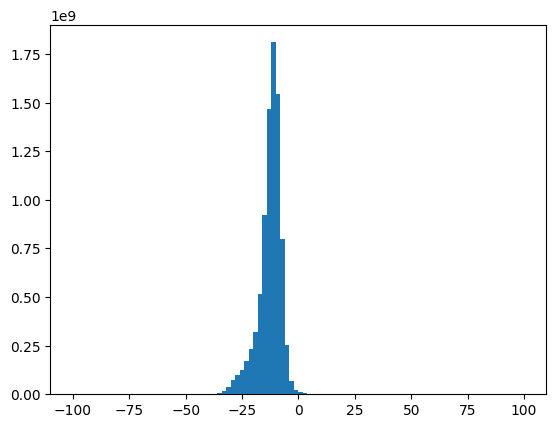

In [14]:
pretty_histogram(histogram_values_1)

In [15]:
stats_result

(array([-75.111374, -74.332146], dtype=float32),
 array([33.597683, 34.60696 ], dtype=float32),
 array([-19.290445, -12.619993], dtype=float32),
 array([5.4644284, 5.115912 ], dtype=float32),
 (array([         0,          0,          0,          0,          0,
                  0,          0,          0,          0,          0,
                  0,          0,          1,          1,          2,
                  7,         11,         27,         64,        119,
                229,        494,       1202,       2956,       7169,
              18749,      47721,     134325,     407450,    1244343,
            4101854,   13386417,   41215354,  109912329,  231453371,
          385311663,  491599113,  452747710,  500091526,  810931513,
         1264146387, 1569442743, 1432725786,  834616209,  269902080,
           60310343,   16848981,    6048717,    2338357,     942886,
             395248,     174201,      87268,      45776,      24860,
              13372,       7294,       3839,     